In [58]:
import numpy as np
import matplotlib.pyplot as plt
import random
from scipy.signal import savgol_filter
from tqdm import tqdm
%matplotlib inline

In [4]:
import sys
np.set_printoptions(threshold=sys.maxsize)

In [5]:
disp_figs = True

In [6]:
M = 4 # Number of Spiking motifs
N = 10 # Number of input neurons
D = 31 # temporal depth of receptive field
T = 1000
dt = 1
nrn_fr = 40 # hz
pg_fr = 4 # hz
background_noise_fr = 0 # h

np.random.seed(41)

In [7]:
# for matplotlib
colors = np.array(['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf'])
len(colors)

10

# Generate the PG Kernels


In [8]:
# I will try and do this with dense and sparse representations at the same time
# Dense K: matrix of binary images of sizeNxDxM
# Sparse K: set of (delay d, neuron a, and pg b)

K_dense = np.random.randint(0,999,(N,D,M))
K_dense[K_dense < nrn_fr] = 1
K_dense[K_dense >= nrn_fr] = 0
K_sparse = np.where(K_dense)

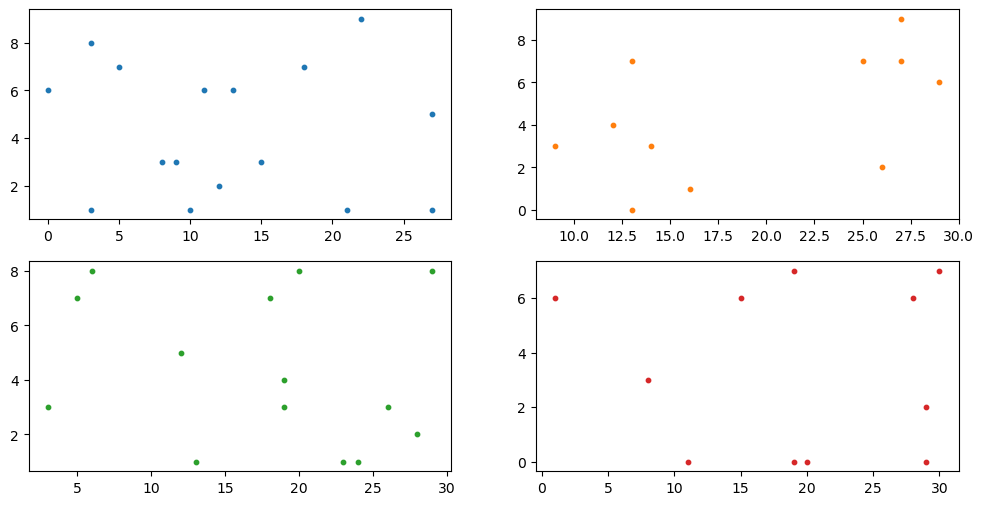

In [9]:

if disp_figs:
    %matplotlib inline
    fig,ax = plt.subplot_mosaic('AB;CD',figsize=(12,6))
    [ax[k].scatter(K_sparse[1][K_sparse[2]==i], K_sparse[0][K_sparse[2]==i],c=colors[i],s=10) for i,k in enumerate(['A','B','C','D'])]

# Generate the PG occurrences

In [10]:
# I suppose I can also do this in sparse and dense
# dense B: the binary image of the occurrences of the spiking motif as a ( M x T) matrix
# spare B: set of all times t and pg's b
B_dense = np.random.randint(0,999,(M,T))
B_dense[B_dense < pg_fr] = 1
B_dense[B_dense >= pg_fr] = 0
B_sparse = np.where(B_dense)

In [11]:
B_sparse[0]

array([0, 0, 0, 0, 0, 1, 1, 1, 2, 3, 3], dtype=int64)

In [12]:
colors[B_sparse[0]]

array(['#1f77b4', '#1f77b4', '#1f77b4', '#1f77b4', '#1f77b4', '#ff7f0e',
       '#ff7f0e', '#ff7f0e', '#2ca02c', '#d62728', '#d62728'], dtype='<U7')

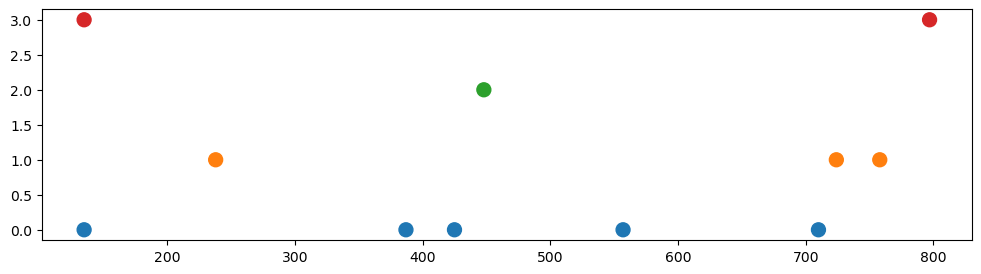

In [13]:
plt.figure(figsize=(12,3))
plt.scatter(B_sparse[1],B_sparse[0],c=colors[B_sparse[0]],s=100)
plt.show()

# Convolve the PG kernels with the PG firing times

In [14]:
background_noise_fr

0

In [15]:
# now to make the full raster plot keeping the labels in-tact
# dense A: the layered binary images of all neuron spikes by PG ( N x T x M
A_dense = np.zeros((N,T+D,M+1))
A_dense[...,-1] = np.random.randint(0,999,(N,T+D))
A_dense[...,-1] = (A_dense[...,-1] < background_noise_fr).astype('int')
for i in range(len(B_sparse[0])):
    t = B_sparse[1][i]
    b = B_sparse[0][i]
    A_dense[:, t:t+D, b] += K_dense[...,b]
    
A_dense.shape
# A_dense = A_dense[:,:1000,:]
A_sparse = np.where(A_dense)
A_dense = np.sum(A_dense,axis=2)
A_dense[A_dense>1] = 1
A_dense.shape

(10, 1031)

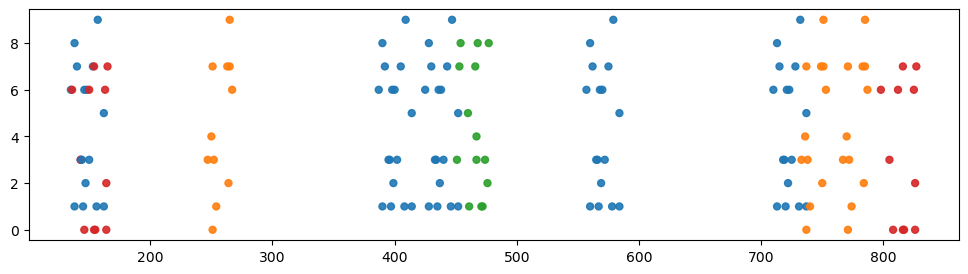

In [16]:
%matplotlib inline
plt.figure(figsize=(12,3))
plt.scatter(A_sparse[1],A_sparse[0],c=colors[A_sparse[2]],alpha=0.9,s=100,marker='.')
plt.show()

# Sanity Check

Let's start with a proof of concept by convolving the answers with the full raster plot :)

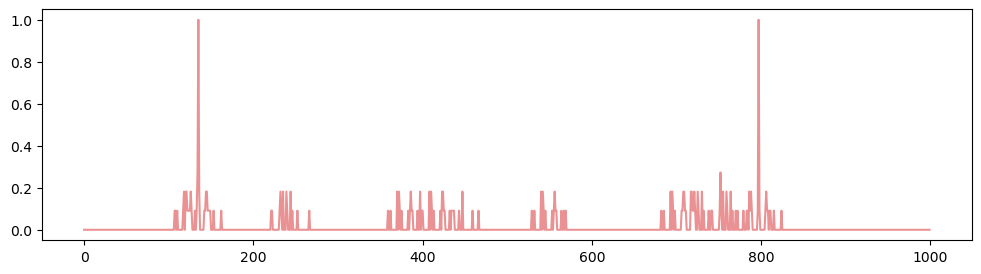

In [17]:
test = np.zeros((T,M))
%matplotlib inline
for j in range(M):
    for i in range(T):
        test[i,j] = np.sum(K_dense[...,j]*A_dense[:,i:i+D])
    test[:,j] = test[:,j]/np.max(test[:,j])
plt.figure(figsize=(12,3))
i = 3
plt.plot(test[:,i],color=colors[i],alpha=0.5)

# Unsupervised Learning

so... why don't I try the flawed window shift method? Even though this loses the spike information

In [18]:
window_dim = (int(np.ceil(D/2)), N)
valid_spikes = (A_sparse[1] > window_dim[0]) & (A_sparse[1] < T- window_dim[0])

 should make sure to have the labels handy...

In [19]:
M_labels = A_sparse[2][valid_spikes]
N_labels = A_sparse[0][valid_spikes]
T_labels = A_sparse[1][valid_spikes]
windows = np.zeros((len(T_labels), N, window_dim[0]*2))
for i,window_time in enumerate(T_labels):
    windows[i,...] = A_dense[:,-window_dim[0]+window_time:window_dim[0]+window_time]
    windows[i,N_labels[i],window_dim[0]] = 2
print('spikes: %d, neurons: %s, depth: %a' %windows.shape)

spikes: 149, neurons: 10, depth: 32


In [20]:
windows.shape

(149, 10, 32)

# kmeans labeling pipeline

In [45]:
import pandas as pd
from scipy.stats import zscore
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [26]:
windows.shape,N_labels.shape

((149, 10, 32), (149,))

In [69]:
N_labels.shape

(149,)

In [78]:
len(windows)

149

In [102]:
windows_sorted = []
kmeans_labels = []
pca_features = []
for n in tqdm(range(N)):
#     w = windows[N_lables==n
    windows_sorted.append(windows[N_labels==n])
    
    temp_window = windows_sorted[-1].reshape(windows_sorted[-1].shape[0],windows_sorted[-1].shape[1]*windows_sorted[-1].shape[2])
    
    z_windows = zscore(temp_window,axis=1)
    z_windows[np.isnan(z_windows)] = 0
    z_windows.shape
    
    pca = PCA(n_components=3)
    pca_features3 = pca.fit_transform(np.transpose(z_windows.T))
    pca_df = pd.DataFrame(data=pca_features3, columns=['PC1', 'PC2','PC3'])

    kmeans = KMeans(
    init="random",
    n_clusters=4,
    n_init=10,
    max_iter=300,
    random_state=42
    )
    
    pca_features.append(pca_features3)

    kmeans.fit(pca_features3)
    kmeans.cluster_centers_
    windows_sorted.append(windows[N_labels==n])
    kmeans_labels.append(kmeans.labels_)


  0%|                                                                                           | 0/10 [00:00<?, ?it/s]C:\Users\miles\anaconda3\envs\mysnn\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
 10%|████████▎                                                                          | 1/10 [00:00<00:02,  4.23it/s]C:\Users\miles\anaconda3\envs\mysnn\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
 20%|████████████████▌                                                                  | 2/10 [00:00<00:01,  4.15it/s]C:\Users\miles\anaconda3\envs\mysnn\Lib\site-

In [92]:
kmeans_labels_all =np.concatenate(kmeans_labels).ravel()
kmeans_labels_all.shape,M_labels.shape

((149,), (149,))

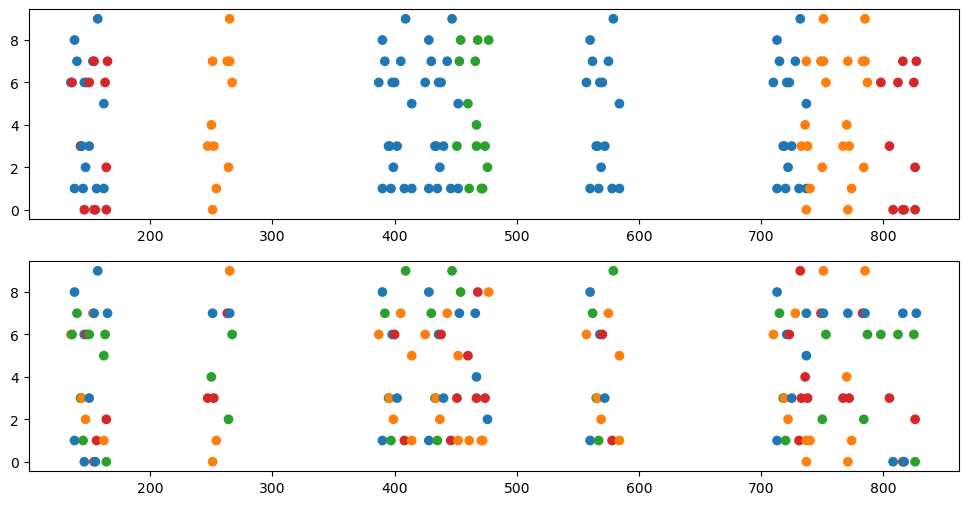

In [98]:
fig,ax = plt.subplot_mosaic('A;B',figsize=(12,6))
ax['A'].scatter(T_labels,N_labels,c=colors[M_labels])
ax['B'].scatter(T_labels,N_labels,c=colors[kmeans_labels_all])

well, pca doesn't work very well when you don't know how many clusters there are...

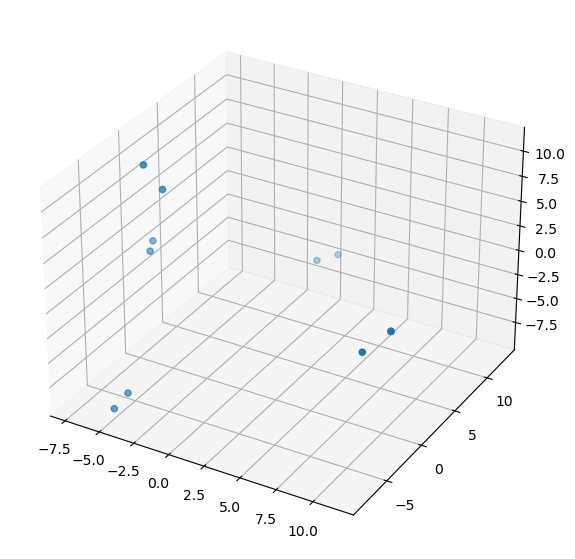

In [103]:
i=0
%matplotlib inline
fig = plt.figure(figsize = (10, 7))
ax2 = plt.axes(projection = "3d")
ax2.scatter3D(pca_features[i].T[0],pca_features[i].T[1],pca_features[i].T[2],c=colors[kmeans.labels_[i]])

plt.show()

In [104]:
kmeans.labels_[i]

0